<a href="https://colab.research.google.com/github/AndreyKuratov/project_mldm_21/blob/main/MLDM_project_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Prepare samples

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
import scipy.signal as signal
import os
from tqdm import tqdm

import os
import csv
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image

import librosa as lb 
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd

from skimage.transform import resize
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from skimage.transform import resize

In [3]:
common_dir = '/content/drive/MyDrive/MLDM_proj/'

In [4]:
dir = common_dir + 'train/'
arr_files = os.listdir(dir)
arr_files[:10]

['ca06bba74.flac',
 'ca0bf5f45.flac',
 'ca8256b82.flac',
 'ca5018f35.flac',
 'ca27aadbb.flac',
 'ca4a30955.flac',
 'ca3f20e1d.flac',
 'ca8192152.flac',
 'ca3ef87e7.flac',
 'caf300f6f.flac']

In [5]:
arr_names = [x[:-5] for x in arr_files]
arr_names[:10]

['ca06bba74',
 'ca0bf5f45',
 'ca8256b82',
 'ca5018f35',
 'ca27aadbb',
 'ca4a30955',
 'ca3f20e1d',
 'ca8192152',
 'ca3ef87e7',
 'caf300f6f']

## Create file with train and test ids 

In [8]:
data_tp = pd.read_csv(common_dir + 'train_tp.csv')

In [9]:
data_tp.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70


In [14]:
tp_names = np.unique(data_tp['recording_id'])

In [17]:
test_ids = np.random.choice(tp_names, size=150, replace=False)

In [30]:
train_ids = np.setdiff1d(arr_names, test_ids)

In [20]:
train_filename = common_dir + 'train_ids.npy'
test_filename = common_dir + 'test_ids.npy'

In [32]:
np.save(train_filename, train_ids)
np.save(test_filename, test_ids)

## Work with train files

In [26]:
train_ids = np.load(common_dir + 'train_ids.npy', allow_pickle=True)

In [33]:
len(train_ids)

4577

In [34]:
data_tp = pd.read_csv(common_dir + 'train_tp.csv')
data_fp = pd.read_csv(common_dir + 'train_fp.csv')

In [39]:
def MinMaxScaling(ar):
  min_ar = min(ar.flatten())
  max_ar = max(ar.flatten())
  return (ar - min_ar)/(max_ar - min_ar)*255

def prepare_image(data, samplerate, size=(256, 512)):
  n_fft = 2048 # number of samples per FFT (the duration of each slice)
  hop_length = 512 # shift

  stft = lb.core.stft(data, hop_length=hop_length, n_fft=n_fft)
  stft_ang = np.angle(stft, deg=False)
  log_stft_ang = librosa.power_to_db(stft_ang, ref=np.max)

  spectrogram = np.abs(stft)
  log_spectrogram = lb.amplitude_to_db(spectrogram)

  mel_spectrogram = lb.feature.melspectrogram(data, n_fft=n_fft, hop_length=hop_length, sr=samplerate)
  log_mel_spectrogram = lb.amplitude_to_db(mel_spectrogram)

  log_stft_ang = MinMaxScaling(resize(log_stft_ang, size)) 
  log_spectrogram = MinMaxScaling(resize(log_spectrogram,size))
  log_mel_spectrogram = MinMaxScaling(resize(log_mel_spectrogram, size))

  return np.stack((log_mel_spectrogram, log_spectrogram, log_stft_ang), axis=-1).astype(np.uint8)

In [36]:
def cut_signal(min_t, max_t, all_time, mask, init_arr):
  all_length = len(mask)
  start = int(min_t / all_time * all_length)
  stop = int(max_t / all_time * all_length) + 1

  signal = init_arr[:, start:stop, :]

  inds = np.arange(len(mask))
  mask[(start <= inds)&(inds < stop)] = False

  return signal, mask

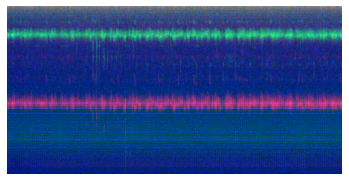

In [40]:
x =  train_ids[0]
data, samplerate = sf.read(dir + x + '.flac')
img = prepare_image(data, samplerate)
plt.imshow(img)
plt.axis('off')
plt.show()

In [41]:
mask = np.ones(img.shape[1], dtype=bool)
min_t = data_fp[data_fp['recording_id'] == x]['t_min'][0]
max_t = data_fp[data_fp['recording_id'] == x]['t_max'][0]
signal, mask = cut_signal(min_t, max_t, data.shape[0]/samplerate, mask, img)

In [42]:
img_new = img[:,mask,:]

In [ ]:
img_new.shape

(256, 502, 3)

In [43]:
plt.imshow(signal)
plt.axis('off')
plt.show()

In [44]:
size = (256, 512)

tp_signals = []
tp_results = []
fp_signals = []
fp_results = []
noises = []

for x in tqdm(train_ids):
  data, samplerate = sf.read(dir + x + '.flac')
  img = prepare_image(data, samplerate, size=size)

  mask = np.ones(img.shape[1], dtype=bool)

    # form tp data
  for row in data_tp[data_tp['recording_id'] == x].itertuples(index=False):
    tp_results.append([row.species_id, row.songtype_id])
    signal, mask = cut_signal(row.t_min, row.t_max, data.shape[0]/samplerate, mask, img)
    tp_signals.append(signal)


    # form fp data
  for row in data_fp[data_fp['recording_id'] == x].itertuples(index=False):
    fp_results.append([row.species_id, row.songtype_id])
    signal, mask = cut_signal(row.t_min, row.t_max, data.shape[0]/samplerate, mask, img)
    fp_signals.append(signal)

    #form noise
  noises.append(img[:, mask, :])

100%|██████████| 4577/4577 [3:56:28<00:00,  3.10s/it]


In [45]:
import pickle

In [46]:
with open(common_dir + 'noises.pkl', 'wb') as f:
  pickle.dump(noises, f)

In [47]:
with open(common_dir + 'tp_signals.pkl', 'wb') as f:
  pickle.dump(tp_signals, f)

with open(common_dir + 'fp_signals.pkl', 'wb') as f:
  pickle.dump(fp_signals, f)

with open(common_dir + 'tp_results.pkl', 'wb') as f:
  pickle.dump(tp_results, f)

with open(common_dir + 'fp_results.pkl', 'wb') as f:
  pickle.dump(fp_results, f)